In [1]:
from kernelforge._fchl19 import flocal_kernel, generate_fchl_acsf, generate_fchl_acsf_and_gradients, flocal_kernel_symm, fatomic_local_gradient_kernel
# import kernelforge
# help(kernelforge._fchl19)
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [2]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
elements=[1, 6, 8]
n_test = 100

In [3]:
Y = train["E"].flatten()
offset = np.mean(Y)
Y -= offset
Yt = test["E"].flatten()[:n_test] - offset

Yft = test["F"][:n_test].flatten()

In [4]:
X = np.asarray([generate_fchl_acsf(r, train["z"], elements=elements) for r in tqdm(train["R"])])
dX = np.asarray([generate_fchl_acsf_and_gradients(r, train["z"], elements=elements)[1] for r in tqdm(train["R"])])
dX.resize(1000,9,312,27)
print(dX.shape)
Q = np.asarray([train["z"] for r in train["R"]])
N = np.asarray([len(train["z"]) for r in train["R"]])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 9, 312, 27)


In [5]:
Xt = np.asarray([generate_fchl_acsf(r, test["z"], elements=elements) for r in tqdm(test["R"][:n_test])])
print(Xt.shape)
dXt = np.asarray([generate_fchl_acsf_and_gradients(r, test["z"], elements=elements)[1] for r in tqdm(test["R"])])
dXt.resize(n_test,9,312,27)
print(dXt.shape)
Qt = np.asarray([train["z"] for r in test["R"][:n_test]])
Nt = np.asarray([len(train["z"]) for r in test["R"][:n_test]])

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 9, 312)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 9, 312, 27)


In [6]:
print(Q.shape)

(1000, 9)


In [7]:
sigma = 2
t0 = time.perf_counter()
# K = flocal_kernel_symm(X, Q, N, sigma)
K = flocal_kernel(X, X, Q, Q, N, N, sigma)

t1 = time.perf_counter()
print(t1-t0)

0.21127920498838648


In [8]:
print(K[:5, :5])

[[36.56205673 36.18353264 36.38832142 36.75741247 36.59730816]
 [36.18353264 36.05427466 36.10143915 36.4471952  36.28464488]
 [36.38832142 36.10143915 36.40329634 36.60667564 36.42631773]
 [36.75741247 36.4471952  36.60667564 37.13615363 36.90021563]
 [36.59730816 36.28464488 36.42631773 36.90021563 36.74719399]]


In [9]:
from kernelforge._kernels import solve_cholesky

In [10]:
K_solve = K.copy()
for i in range(K_solve.shape[0]):
    K_solve[i,i] += 1e-8
alphas = solve_cholesky(K_solve, Y)
alphas

array([-1.31414514e+05,  4.10049630e+04, -8.71673425e+04, -1.07719889e+05,
        1.52984207e+05,  7.31251891e+04,  2.42719188e+05, -6.27990344e+05,
        8.76153190e+04, -1.17395821e+05, -8.55332064e+04,  2.37550742e+05,
       -7.49724571e+04, -5.60217120e+03,  5.94163365e+04, -1.25270255e+05,
        3.47603673e+04, -2.61759177e+05,  1.79847543e+05, -3.30484365e+05,
        1.32648865e+05,  3.24797660e+04, -1.15498572e+05,  1.55339720e+05,
       -4.18571372e+05, -2.26166439e+05,  1.26713059e+05, -4.59069140e+04,
        6.24805922e+04, -3.46104761e+05, -2.87316446e+05,  1.08912952e+04,
       -1.15537615e+05, -6.60819057e+04,  4.64332034e+02,  1.11973110e+05,
        2.20707422e+05, -2.57719158e+05, -2.89539839e+05, -7.17901954e+04,
        1.58779915e+05, -2.73773629e+05,  6.09239548e+04, -5.85520394e+04,
        7.29474395e+04,  1.64066613e+05, -7.99282234e+04,  4.88153141e+04,
       -9.85416637e+03, -2.64115066e+04,  2.72597984e+05, -6.37952413e+04,
        7.80133670e+04, -

In [11]:
t0 = time.perf_counter()
Kt = flocal_kernel(Xt, X, Qt, Q, Nt, N, sigma)
t1 = time.perf_counter()
print(t1-t0)

0.0641219739918597


In [12]:
Yp = Kt @ alphas

RMSE = 0.23526487913624997
PearsonRResult(statistic=np.float64(0.9986700456734897), pvalue=np.float64(5.129785856239704e-128))


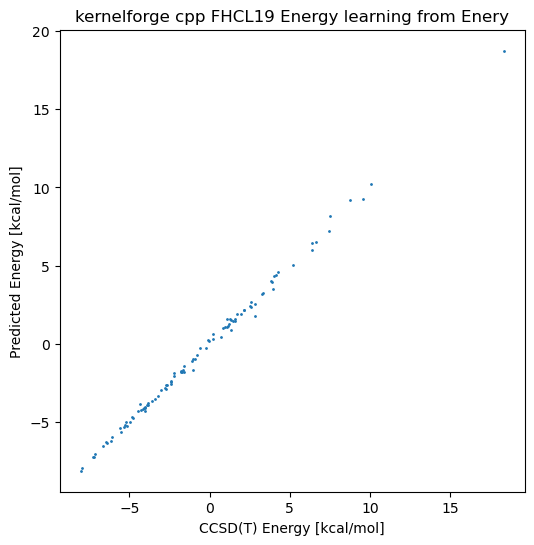

In [13]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yp, Yt)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.title("kernelforge cpp FHCL19 Energy learning from Enery")
plt.scatter(Yt, Yp, s=1)

In [14]:
t0 = time.perf_counter()
Kd = fatomic_local_gradient_kernel(X, Xt, dXt, Q, Qt, N, Nt, sigma).T
t1 = time.perf_counter()
print(t1-t0)

1.5108015229925513


In [15]:
Kd.shape

(2700, 1000)

In [16]:
Yfp = Kd @ alphas
Yfp.shape

(2700,)

In [17]:
Yft.shape

(2700,)

RMSE = 1.536321548795515
PearsonRResult(statistic=np.float64(0.9983916248723087), pvalue=np.float64(0.0))


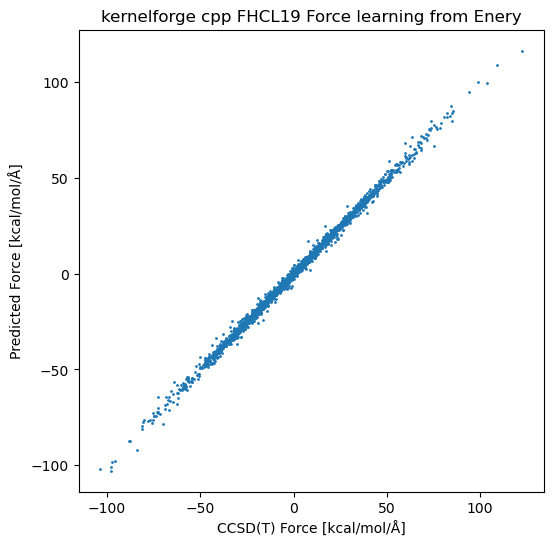

In [18]:
rmse = np.sqrt(np.mean(np.square(Yft - Yfp)))
res = pearsonr(Yfp, Yft)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")
plt.title("kernelforge cpp FHCL19 Force learning from Enery")
plt.scatter(Yft, Yfp, s=1)